## Public Score:  0.8209

# Дневник улучшений

Для начала отмечу, что скоры, которые представлены ниже, были расчитаны на валидационной выборке. 

Точка отсчета (baseline with 1000 iterations): 0.7595

1) Генерация признаков:
- Временные признаки (интервал между первым и последним действием): +0.0005 
- Добавлены признаки о действиях пользователя за последние 7, 14, 21, 30 дней: +0.0003
- Добавлена статистика по категориям товаров: +0.0003

2) Интерпретация модели:
- Созданы комбинации важных признаков: +0.0004

3) Понижение размерности:
- UMAP 2D + кластерные метки как признаки: -0.0001

4) Кластеризация:
- KMeans (k=5) на основе поведенческих признаков: -0.0001

5) Ближайшие соседи:
- Средний таргет среди 10 ближайших соседей: +0.0000

6) Тюнинг гиперпараметров:
- Оптимизация depth, eta и использования нескольких лучших моделей с разными весами: +0.0013

Итоговый скор: 0.7623


In [2]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
import umap

In [3]:
test_start_date = date(2024, 8, 1)

In [4]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = '.'

# Read data

In [5]:
actions_history = pd.read_parquet(os.path.join(data_path, 'actions_history'))
search_history = pd.read_parquet(os.path.join(data_path, 'search_history'))
product_information = pd.read_csv(os.path.join(data_path, 'product_information.csv'))

In [9]:
pd.read_csv(os.path.join(data_path, 'action_type_info.csv'))

,action_type,action_type_id
0,click,1
1,favorite,2
2,order,3
3,search,4
4,to_cart,5
5,view,6


In [48]:
val_target = (
    actions_history[
        (actions_history['timestamp'].dt.date >= val_start_date) &
        (actions_history['timestamp'].dt.date <= val_end_date)
    ]
    .assign(has_order=lambda x: (x['action_type_id'] == 3).astype(int))
    .groupby('user_id', as_index=False)
    .agg(target=('has_order', 'max'))
)

In [69]:
val_target.target.value_counts()

target
0    1227381
1     647575
Name: count, dtype: int64

# Pipeline

## Генерация признаков

In [61]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite",
    3: "order",
    5: "to_cart",
}

for id_, suf in actions_id_to_suf.items():
    filtered_data = actions_history[
        (actions_history['timestamp'].dt.date <= train_end_date) &
        (actions_history['timestamp'].dt.date >= train_end_date - timedelta(days=30 * 4)) &
        (actions_history['action_type_id'] == id_)
    ]
    
    merged_data = filtered_data.merge(
        product_information[['product_id', 'discount_price']],
        on='product_id',
        how='left'
    )
    
    aggs = merged_data.groupby('user_id', as_index=False).agg(
        num_products=('product_id', 'count'),
        sum_discount_price=('discount_price', 'sum'),
        max_discount_price=('discount_price', 'max'),
        min_discount_price=('discount_price', 'min'),
        mean_discount_price=('discount_price', 'mean'),
        last_time=('timestamp', 'max'),
        first_time=('timestamp', 'min')
    )

    cat_stats = filtered_data.merge(product_information, on='product_id').groupby('user_id')['category_id'].agg([
        ('unique_categories', 'nunique'),
        ('most_common_category', lambda x: x.mode()[0])
    ]).reset_index()

    aggs = aggs.merge(cat_stats, on='user_id', how='left')
    
    aggs = aggs.rename(columns={
        'num_products': f'num_products_{suf}',
        'sum_discount_price': f'sum_discount_price_{suf}',
        'max_discount_price': f'max_discount_price_{suf}',
        'min_discount_price': f'min_discount_price_{suf}',
        'mean_discount_price': f'mean_discount_price_{suf}',
        'last_time': f'last_{suf}_time',
        'first_time': f'first_{suf}_time',
        'unique_categories': f'unique_categories_{suf}',
        'most_common_category': f'most_common_category_{suf}'
    })
    
    aggs[f'days_since_last_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'last_{suf}_time']).dt.days
    aggs[f'days_since_first_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'first_{suf}_time']).dt.days
    aggs[f'days_difference_{suf}'] = aggs[f'days_since_last_{suf}'] - aggs[f'days_since_first_{suf}'] #new
    aggs[f'num_products_{suf}'] = aggs[f'num_products_{suf}'].fillna(0) 
    aggs[f'sum_discount_price_{suf}'] = aggs[f'sum_discount_price_{suf}'].fillna(0) 
    aggs[f'max_discount_price_{suf}'] = aggs[f'max_discount_price_{suf}'].fillna(0) 
    

    for i in [7, 14, 21, 30]:
        filtered_data = actions_history[
            (actions_history['timestamp'].dt.date <= train_end_date) &
            (actions_history['timestamp'].dt.date >= train_end_date - timedelta(days=i)) &
            (actions_history['action_type_id'] == id_)
        ]
        
        merged_data = filtered_data.merge(
            product_information[['product_id', 'discount_price']],
            on='product_id',
            how='left'
        )
        
        aggs_add = merged_data.groupby('user_id', as_index=False).agg(
            num_products=('product_id', 'count'),
            sum_discount_price=('discount_price', 'sum'),
        )

        aggs_add = aggs_add.rename(columns={
            'num_products': f'num_products_{suf}_{i}',
            'sum_discount_price': f'sum_discount_price_{suf}_{i}',
        })

        aggs = aggs.merge(aggs_add, on='user_id', how='left')
    
    actions_aggs[id_] = aggs

In [63]:
# search_aggs
id_ = 4
suf = 'search'

filtered_data = search_history[
    (search_history['action_type_id'] == id_) &
    (search_history['timestamp'].dt.date <= train_end_date) &
    (search_history['timestamp'].dt.date >= train_end_date - timedelta(days=30 * 4))
]
aggs = filtered_data.groupby('user_id', as_index=False).agg(
    num_search=('search_query', 'count'),
    last_search_time=('timestamp', 'max'),
    first_search_time=('timestamp', 'min')
)

aggs = aggs.rename(columns={
    'num_search': f'num_{suf}',
    'last_search_time': f'last_{suf}_time',
    'first_search_time': f'first_{suf}_time'
})

aggs[f'days_since_last_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'last_{suf}_time']).dt.days
aggs[f'days_since_first_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'first_{suf}_time']).dt.days
aggs[f'days_difference_{suf}'] = aggs[f'days_since_last_{suf}'] - aggs[f'days_since_first_{suf}'] #new
aggs[f'num_{suf}'] = aggs[f'num_{suf}'].fillna(0) #new

aggs = aggs[[
    'user_id',
    f'num_{suf}',
    f'days_since_last_{suf}',
    f'days_since_first_{suf}',
    f'days_difference_{suf}'
]]

actions_aggs[id_] = aggs

In [64]:
df = val_target

for _, actions_aggs_df in actions_aggs.items():
    df = df.merge(actions_aggs_df, on='user_id', how='left')

In [66]:
for id_, suf in actions_id_to_suf.items():
    df[f'num_products_{suf}'] = df[f'num_products_{suf}'].fillna(0) #new
    df[f'sum_discount_price_{suf}'] = df[f'sum_discount_price_{suf}'].fillna(0) #new
    df[f'max_discount_price_{suf}'] = df[f'max_discount_price_{suf}'].fillna(0) #new
    for i in [7, 14, 21, 30]:
        df[f'num_products_{suf}_{i}'] = df[f'num_products_{suf}_{i}'].fillna(0) #new
        df[f'sum_discount_price_{suf}_{i}'] = df[f'sum_discount_price_{suf}_{i}'].fillna(0) #new
df['num_search'] = df['num_search'].fillna(0) #new

In [133]:
df_pd = df

In [82]:
mask = df_pd.user_id % 10 <= 6

In [148]:
cols = df_pd.columns.drop(['user_id', 'target', 'last_click_time', 'first_click_time', \
                          'last_favorite_time', 'first_favorite_time', \
                          'last_order_time', 'first_order_time', \
                          'last_to_cart_time', 'first_to_cart_time',])

In [86]:
train_pool = catboost.Pool(
    df_pd.loc[mask, cols],
    label=df_pd.loc[mask].target,
)
eval_pool = catboost.Pool(
    df_pd.loc[~mask, cols],
    label=df_pd.loc[~mask].target,
)

In [88]:
params = {
    'iterations': 1000,
    'depth': 7, 
    'learning_rate': 0.1, 
    'random_state': 1,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'task_type': 'CPU',
}

In [ ]:
model = catboost.CatBoost(params)
model.fit(
    train_pool, 
    eval_set=eval_pool,
    use_best_model=True,
    verbose=50,
    early_stopping_rounds=200,
)

## Интерпретация построенных моделей град. бустинга

In [90]:
name = 'baseline_1'
model.save_model(f"{name}.bin")

In [91]:
fi = model.get_feature_importance(eval_pool, prettified=True)
fi.head(50)

,Feature Id,Importances
0,num_products_order_30,12.600938
1,sum_discount_price_to_cart,5.750221
2,sum_discount_price_order,4.994190
3,num_products_order,4.849016
4,days_since_last_order,4.663274
5,sum_discount_price_order_30,3.809937
6,num_search,3.431922
7,days_since_first_order,3.194121
8,days_difference_order,2.760496
9,unique_categories_click,2.389001


In [117]:
from typing import List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator

def feature_error_cor(
    model: BaseEstimator,
    df: pd.DataFrame,
    cols: List[str],
    n: int = 30
) -> None:
    """
    Анализирует ошибки модели и выводит тепловую карту корреляции признаков с величиной ошибки.

    Параметры:
    ----------
    model : sklearn.base.BaseEstimator
        Обученная модель с методом predict_proba().
    df : pandas.DataFrame
        Датафрейм, содержащий признаки и целевую переменную 'target'.
    cols : List[str]
        Список признаков, для которых вычисляется корреляция с ошибкой предсказания.
    n : int, optional (default=30)
        Количество топовых признаков для отображения.

    Возвращяеи:
    -----------
    None
        Функция выводит:
        1) Статистику по ошибочным предсказаниям
        2) Тепловую карту корреляции признаков с величиной ошибки
    """
    # Вероятности
    test_predictions: np.ndarray = model.predict(df[cols], prediction_type="Probability")[:, 1]
    
    # Создаем датафрейм с ошибочными предсказаниями
    wrong_predictions: pd.DataFrame = df.assign(
        predicted_prob=test_predictions,
        predicted_class=(test_predictions > 0.5).astype(int)
    ).query(
        "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
    ).copy()
    
    # Вычисляем величину ошибки (разница между предсказанием и таргетом)
    wrong_predictions['error_magnitude']: pd.Series = np.abs(
        wrong_predictions['predicted_prob'] - wrong_predictions['target']
    )

    # Общая статистика по предсказаниям
    print(f"Всего ошибочных предсказаний: {len(wrong_predictions)}")
    print(f"Доля ошибок: {len(wrong_predictions)/len(df):.2%}")

    # Ложно положительные и ложно отрицательные предсказания. 
    fp: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 0]
    fn: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 1]

    print(f"Неверно предсказали 1 (FP): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
    print(f"Неверно предсказали 0 (FN): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")

    # Вычисляем корреляцию признаков с велечиной ошибки. 
    corr_data: pd.DataFrame = wrong_predictions[cols].corrwith(
        wrong_predictions['error_magnitude']
    ).to_frame('correlation')
    
    # Сортируем и выводим n
    corr_data_sorted: pd.DataFrame = corr_data.sort_values(
        'correlation', 
        key=abs, 
        ascending=False
    ).head(n)

    # Строим хитмэп
    plt.figure(figsize=(6, 20))
    sns.heatmap(
        corr_data_sorted,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt='.2f',
        cbar_kws={'orientation': 'horizontal'}
    )
    plt.title('Корреляция признаков с величиной ошибки')
    plt.tight_layout()
    plt.show()

Всего ошибочных предсказаний: 437349
Доля ошибок: 23.33%
Неверно предсказали 1 (FP): 99460 (22.74%)
Неверно предсказали 0 (FN): 337889 (77.26%)


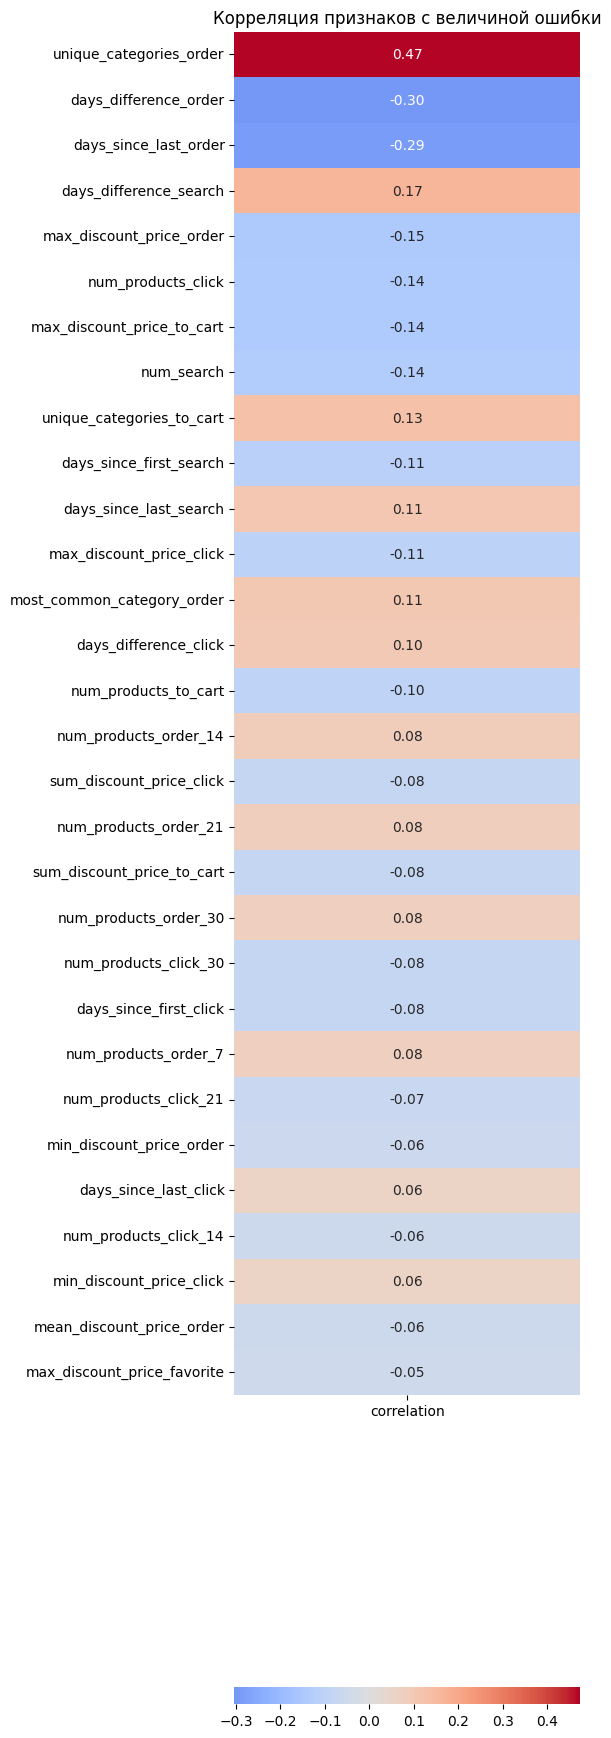

In [118]:
feature_error_cor(model, df, cols)

График иллюстрирует зависимость величины ошибки модели от значений каждого признака.

Сильная положительная корреляция указывает на то, что при увеличении значения данного признака величина ошибки модели также возрастает. В случае отрицательной корреляции, наоборот, снижение значения признака приводит к увеличению ошибки.

Далее, для генерации новых признаков с помощью комбинации признаков с высокой важностью мы не будем использовать признаки с сильной положительной и отрицательной корреляцией.

### GoldenFeatures

In [154]:
df_pd['unique_categories_to_cart_sum_sum_discount_price_order_30'] = df_pd['unique_categories_to_cart'] + \
df_pd['sum_discount_price_order_30']
df_pd['num_products_to_cart_sum_sum_discount_price_order_30'] = df_pd['num_products_to_cart'] + \
df_pd['sum_discount_price_order_30']
df_pd['num_search_sum_sum_discount_price_order_30'] = df_pd['num_search'] + \
df_pd['sum_discount_price_order_30']
df_pd['num_products_to_cart_sum_sum_discount_price_order_21'] = df_pd['num_products_to_cart'] + \
df_pd['sum_discount_price_order_21']
df_pd['days_since_first_to_cart_sum_sum_discount_price_order_30'] = df_pd['days_since_first_to_cart'] + \
df_pd['sum_discount_price_order_30']
df_pd['unique_categories_to_cart_sum_sum_discount_price_order_21'] = df_pd['unique_categories_to_cart'] + \
df_pd['sum_discount_price_order_21']
df_pd['sum_discount_price_order_30_diff_unique_categories_to_cart'] = df_pd['sum_discount_price_order_30'] - \
df_pd['unique_categories_to_cart']
df_pd['sum_discount_price_order_30_diff_days_since_last_to_cart'] = df_pd['sum_discount_price_order_30'] - \
df_pd['days_since_last_to_cart']
df_pd['sum_discount_price_order_30_diff_days_difference_search'] = df_pd['sum_discount_price_order_30'] - \
df_pd['days_difference_search']
df_pd['days_since_first_to_cart_sum_sum_discount_price_order'] = df_pd['days_since_first_to_cart'] + \
df_pd['sum_discount_price_order']

## Понижение размерности

In [126]:
important_cols = fi['Feature Id'][:20]

In [ ]:
import umap
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(df_pd[important_cols].fillna(0))
df_pd['umap_x'] = embedding[:,0]
df_pd['umap_y'] = embedding[:,1]

## Кластеризация

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
df_pd['cluster'] = kmeans.fit_predict(df_pd[important_cols].fillna(0))

## Ближайшие соседи

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbor_target = []
nbrs = NearestNeighbors(n_neighbors=10).fit(df_pd[important_cols].fillna(0))
_, indices = nbrs.kneighbors(df_pd[cols].fillna(0))
for i in range(len(df_pd)):
    neighbor_target.append(df_pd.iloc[indices[i].flatten()]['target'].mean())

df_pd['neighbor_target_mean'] = neighbor_target

## Тюнинг гиперпараметров бустинга

In [ ]:
import optuna
import numpy as np
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [1000]),
        'depth': trial.suggest_int('depth', 4, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'random_state': 1,
        'early_stopping_rounds': 50,
        'task_type': 'СPU',
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=eval_pool,
        use_best_model=True
    )
    return model.get_best_score()['validation']['AUC']

# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

В итоге были выбраны следующие модели ( _GoldenFeatures - использование GoldenFeatures, полученных ранее):

#### Ensemble structure
| Model                      |   Weight |
|:---------------------------|---------:|
| 1_CatBoost                |        4 |
| 2_CatBoost_GoldenFeatures |        3 |
| 3_CatBoost_GoldenFeatures |        5 |
| 4_CatBoost_GoldenFeatures |        8 |

#### 1_CatBoost
- **eta**: 0.1
- **depth**: 9
#### 2_CatBoost_GoldenFeatures
- **eta**: 0.1
- **depth**: 9
#### 3_CatBoost_GoldenFeatures
- **eta**: 0.2
- **depth**: 7
#### 4_CatBoost_GoldenFeatures
- **eta**: 0.05
- **depth**: 9

Далее проделаны аналогичные операции, но с тестовым датасетом.

In [92]:
test_users_submission = (
    pd.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [94]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite",
    3: "order",
    5: "to_cart",
}

for id_, suf in actions_id_to_suf.items():
    filtered_data = actions_history[
        (actions_history['timestamp'].dt.date <= val_end_date) &
        (actions_history['timestamp'].dt.date >= val_end_date - timedelta(days=30 * 4)) &
        (actions_history['action_type_id'] == id_)
    ]
    
    merged_data = filtered_data.merge(
        product_information[['product_id', 'discount_price']],
        on='product_id',
        how='left'
    )
    
    aggs = merged_data.groupby('user_id', as_index=False).agg(
        num_products=('product_id', 'count'),
        sum_discount_price=('discount_price', 'sum'),
        max_discount_price=('discount_price', 'max'),
        min_discount_price=('discount_price', 'min'),
        mean_discount_price=('discount_price', 'mean'),
        last_time=('timestamp', 'max'),
        first_time=('timestamp', 'min')
    )

    cat_stats = filtered_data.merge(product_information, on='product_id').groupby('user_id')['category_id'].agg([
        ('unique_categories', 'nunique'),
        ('most_common_category', lambda x: x.mode()[0])
    ]).reset_index()

    aggs = aggs.merge(cat_stats, on='user_id', how='left')
    
    aggs = aggs.rename(columns={
        'num_products': f'num_products_{suf}',
        'sum_discount_price': f'sum_discount_price_{suf}',
        'max_discount_price': f'max_discount_price_{suf}',
        'min_discount_price': f'min_discount_price_{suf}',
        'mean_discount_price': f'mean_discount_price_{suf}',
        'last_time': f'last_{suf}_time',
        'first_time': f'first_{suf}_time',
        'unique_categories': f'unique_categories_{suf}',
        'most_common_category': f'most_common_category_{suf}'
    })
    
    aggs[f'days_since_last_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'last_{suf}_time']).dt.days
    aggs[f'days_since_first_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'first_{suf}_time']).dt.days
    aggs[f'days_difference_{suf}'] = aggs[f'days_since_last_{suf}'] - aggs[f'days_since_first_{suf}'] #new
    aggs[f'num_products_{suf}'] = aggs[f'num_products_{suf}'].fillna(0) #new
    aggs[f'sum_discount_price_{suf}'] = aggs[f'sum_discount_price_{suf}'].fillna(0) #new
    aggs[f'max_discount_price_{suf}'] = aggs[f'max_discount_price_{suf}'].fillna(0) #new

    for i in [7, 14, 21, 30]:
        filtered_data = actions_history[
            (actions_history['timestamp'].dt.date <= val_end_date) &
            (actions_history['timestamp'].dt.date >= val_end_date - timedelta(days=i)) &
            (actions_history['action_type_id'] == id_)
        ]
        
        merged_data = filtered_data.merge(
            product_information[['product_id', 'discount_price']],
            on='product_id',
            how='left'
        )
        
        aggs_add = merged_data.groupby('user_id', as_index=False).agg(
            num_products=('product_id', 'count'),
            sum_discount_price=('discount_price', 'sum'),
        )

        aggs_add = aggs_add.rename(columns={
            'num_products': f'num_products_{suf}_{i}',
            'sum_discount_price': f'sum_discount_price_{suf}_{i}',
        })

        aggs = aggs.merge(aggs_add, on='user_id', how='left')
    
    actions_aggs[id_] = aggs

In [95]:
# search_aggs
id_ = 4
suf = 'search'

filtered_data = search_history[
    (search_history['action_type_id'] == id_) &
    (search_history['timestamp'].dt.date <= val_end_date) &
    (search_history['timestamp'].dt.date >= val_end_date - timedelta(days=30 * 4))
]
aggs = filtered_data.groupby('user_id', as_index=False).agg(
    num_search=('search_query', 'count'),
    last_search_time=('timestamp', 'max'),
    first_search_time=('timestamp', 'min')
)

aggs = aggs.rename(columns={
    'num_search': f'num_{suf}',
    'last_search_time': f'last_{suf}_time',
    'first_search_time': f'first_{suf}_time'
})

aggs[f'days_since_last_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'last_{suf}_time']).dt.days
aggs[f'days_since_first_{suf}'] = (pd.to_datetime(val_start_date) - aggs[f'first_{suf}_time']).dt.days
aggs[f'days_difference_{suf}'] = aggs[f'days_since_last_{suf}'] - aggs[f'days_since_first_{suf}'] #new
aggs[f'num_{suf}'] = aggs[f'num_{suf}'].fillna(0) #new

aggs = aggs[[
    'user_id',
    f'num_{suf}',
    f'days_since_last_{suf}',
    f'days_since_first_{suf}',
    f'days_difference_{suf}'
]]

actions_aggs[id_] = aggs

In [96]:
df_test = test_users_submission

for _, actions_aggs_df in actions_aggs.items():
    df_test = df_test.merge(actions_aggs_df, on='user_id', how='left')

In [97]:
for id_, suf in actions_id_to_suf.items():
    df[f'num_products_{suf}'] = df[f'num_products_{suf}'].fillna(0) #new
    df[f'sum_discount_price_{suf}'] = df[f'sum_discount_price_{suf}'].fillna(0) #new
    df[f'max_discount_price_{suf}'] = df[f'max_discount_price_{suf}'].fillna(0) #new
    for i in [7, 14, 21, 30]:
        df[f'num_products_{suf}_{i}'] = df[f'num_products_{suf}_{i}'].fillna(0) #new
        df[f'sum_discount_price_{suf}_{i}'] = df[f'sum_discount_price_{suf}_{i}'].fillna(0) #new
df['num_search'] = df['num_search'].fillna(0) #new

In [98]:
df_pd = df_test

Тут нужно прогнать все 4 модели:

In [ ]:
train_pools = [train_pool_1, train_pool_2, train_pool_3, train_pool_4]

In [ ]:
ans = []
for depth_i, eta_i, i in zip([9, 9, 7, 9], [0.1, 0.1, 0.2, 0.05], [0, 1, 2, 3]):
    best_params = {
            'iterations': 1000,
            'depth': depth_i, 
            'eta': eta_i, 
            'random_state': 1,
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'task_type': 'CPU',
    }
    
    model = CatBoostClassifier(**best_params)
    model.fit(
        train_pools[i], 
        eval_set=eval_pool,
        use_best_model=True,
        verbose=100
    )

    ans.append(model.predict(df_pd[cols], prediction_type="Probability")[:, 1])

In [152]:
df_pd['predict'] = (ans[0]*4 + ans[1]*3 + ans[2]*5 + ans[3]*8) / 20

In [103]:
df_pd[['user_id', 'predict']].to_csv('baseline_1_submission.csv', index=False)